
##Componentes principales

El objetivo del Notebook es ejemplificar el uso e interpretación de componentes principales como técnica de reducción de dimensionalidad.

Componentes principales nos permite entender la estructura de los datos y saber si es posible hacer una reducción de dimensiones a partir de una factorización de la matriz de covarianzas (correlaciones) de los datos.

Componentes principales está basado en la técnica de descomposición de matrices llamada singular value decomposition (SVD).

El libro contiene un ejemplo relacionado con scoring y otro con investigación de mercados.
Instalemos librerías:

In [1]:
install.packages(c("corrplot","psych","FactoMineR","factoextra","reshape2","RColorBrewer"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Deriv’, ‘microbenchmark’, ‘doBy’, ‘SparseM’, ‘MatrixModels’, ‘minqa’, ‘nloptr’, ‘RcppEigen’, ‘lazyeval’, ‘carData’, ‘Formula’, ‘pbkrtest’, ‘quantreg’, ‘lme4’, ‘crosstalk’, ‘estimability’, ‘numDeriv’, ‘mvtnorm’, ‘viridis’, ‘ggsci’, ‘cowplot’, ‘ggsignif’, ‘gridExtra’, ‘polynom’, ‘rstatix’, ‘mnormt’, ‘GPArotation’, ‘car’, ‘DT’, ‘ellipse’, ‘emmeans’, ‘flashClust’, ‘leaps’, ‘multcompView’, ‘scatterplot3d’, ‘ggrepel’, ‘abind’, ‘dendextend’, ‘ggpubr’, ‘plyr’




#Ejercicio 1
##Data understanding & preparation

Primero importemos la base de datos

In [2]:
cartera<-read.csv("cartera.csv", header=TRUE, sep=";", dec=",")
str(cartera)

'data.frame':	852 obs. of  9 variables:
 $ MESES             : int  41 27 40 41 24 41 39 43 24 36 ...
 $ tipoips           : int  3 1 1 1 2 2 1 1 1 1 ...
 $ igualowner        : int  17 10 15 15 2 5 20 12 3 0 ...
 $ yearsadress       : int  12 6 14 14 0 5 9 11 4 13 ...
 $ ventasmesaverage  : int  176 31 55 120 28 25 67 38 19 25 ...
 $ pasivo_sobre_venta: num  9.3 17.3 5.5 2.9 17.3 10.2 30.6 3.6 24.4 19.7 ...
 $ carteraA          : num  11.36 1.36 0.86 2.66 1.79 ...
 $ carteraB          : num  5.01 4 2.17 0.82 3.06 ...
 $ retrasos          : int  1 0 0 0 1 0 0 0 1 0 ...


El archivo contiene datos de clientes de un proveedor de instituciones de salud (IPS), la cartera que presentan y si se han retrasado o no. Se trata entonces de un negocio B2B en el sector de la salud que desea predecir o averiguar indicadores de posibles aumentos y retrasos en su cartera.

En nuestro caso el tipo de Ips es una variable categórica y debe ser removida (variable # 2). Como nuestro objetivo es ver la estructura de los datos escalares antes de predecir si la IPS se retrasa o no también vamos a eliminar la variable retrasos (variable #9)

In [4]:
quita<-c(2,9)
carteraz<-cartera[,-quita]

# Condiciones para aplicación de ACP

Para que la solución de componentes principales logre su objetivo de reducción de variables es importante que haya correlaciones entre las variables; de otro modo, la reducción no será posible. También, es usual, aplicar 2 criterios estadísticos para asegurar esta reducción:

*   Prueba de esfericidad de Bartlett
*   Indice KMO

Analicemos primero las correlaciones entre variables

In [5]:
cov(carteraz)

,MESES,igualowner,yearsadress,ventasmesaverage,pasivo_sobre_venta,carteraA,carteraB
MESES,66.10326983,30.490770,32.997391,148.021240,-0.07657327,4.739356,9.100186
igualowner,30.49077032,45.947649,16.115410,162.615261,-1.54382941,5.494452,9.524674
yearsadress,32.99739053,16.115410,47.466869,82.323127,-1.55239017,2.359162,4.331092
ventasmesaverage,148.02123986,162.615261,82.323127,1491.826595,-9.49114822,44.982173,78.554120
pasivo_sobre_venta,-0.07657327,-1.543829,-1.552390,-9.491148,45.07590137,7.345703,13.053003
carteraA,4.73935607,5.494452,2.359162,44.982173,7.34570301,4.511305,4.650973
carteraB,9.10018644,9.524674,4.331092,78.554120,13.05300335,4.650973,11.526875


corrplot 0.94 loaded



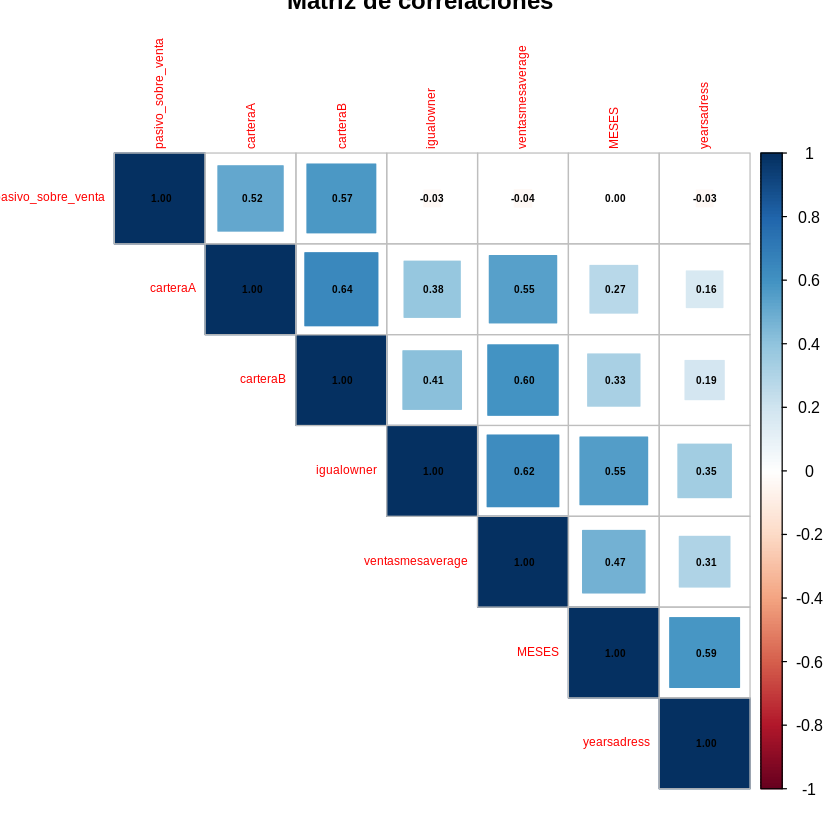

In [6]:
library("corrplot")
#creo matriz de correlaciones
base<-cor(carteraz)
#ejecuto el gráfico
corrplot(base, type="upper",method="square",title="Matriz de correlaciones", tl.cex=0.6,order="hclust", addCoef.col = "black", number.cex=0.5)

El gráfico muestra una moderada correlación positiva entre algunas variables, por lo que alguna reducción puede ser viable.

# Prueba de esfericidad de Bartlett

La prueba de Bartlett compara la matriz de correlaciones observada con la matriz de identidad. En otras palabras comprueba si existe cierta redundancia entre las variables que podamos resumir con un número reducido de factores. Si las variables están perfectamente correlacionadas, basta con un solo factor. Si son ortogonales, necesitamos tantos factores como variables. En este último caso, la matriz de correlaciones es igual que la matriz de identidad. Una estrategia sencilla consiste en visualizar la matriz de correlaciones.

In [7]:
library("psych")
cortest.bartlett(base, n = nrow(cartera))

$chisq
[1] 2952.067

$p.value
[1] 0

$df
[1] 21

#Indice KMO

El índice KMO tiene el mismo objetivo de Bartlett. Comprueba si podemos factorizar eficazmente las variables originales. Pero se basa en otra idea.
La matriz de correlaciones es siempre el punto de partida. Sabemos que las variables están más o menos correlacionadas, pero la correlación entre dos variables puede estar influida por las demás. Así pues, utilizamos la correlación parcial para medir la relación entre dos variables eliminando el efecto de las variables restantes. El índice KMO compara los valores de las correlaciones entre variables y los de las correlaciones parciales. Si el índice KMO es alto, el ACP puede actuar eficazmente; si KMO es bajo, el ACP no es pertinente.

Los siguientes criterios son usados para evaluar el KMO:
*   Sobre 0.90 - Maravilloso
*   0.80 a 0.90 - Meritorio
*   0.70 a 0.80 - Promedio
*   0.60 a 0.70 - Mediocre
*   0.50 a 0.60 - Terrible
*   Bajo 0.50 - Inaceptable

También se puede calcular un índice KMO por variable para detectar las que no están relacionadas con las otras

In [8]:
KMO(base)

Kaiser-Meyer-Olkin factor adequacy
Call: KMO(r = base)
Overall MSA =  0.65
MSA for each item = 
             MESES         igualowner        yearsadress   ventasmesaverage 
              0.75               0.85               0.71               0.59 
pasivo_sobre_venta           carteraA           carteraB 
              0.36               0.73               0.65 

In [9]:
partial.r(carteraz)

,MESES,igualowner,yearsadress,ventasmesaverage,pasivo_sobre_venta,carteraA,carteraB
MESES,1.000000000,0.318068667,0.498665583,0.08888361,0.004218951,-0.018901133,0.04439837
igualowner,0.318068667,1.000000000,0.008838206,0.24055213,-0.120366164,0.096676982,0.09353904
yearsadress,0.498665583,0.008838206,1.000000000,0.03634685,-0.007852106,-0.002478966,-0.02054134
ventasmesaverage,0.088883608,0.240552132,0.036346855,1.00000000,-0.597214353,0.445566967,0.57428056
pasivo_sobre_venta,0.004218951,-0.120366164,-0.007852106,-0.59721435,1.000000000,0.496153374,0.65497018
carteraA,-0.018901133,0.096676982,-0.002478966,0.44556697,0.496153374,1.000000000,-0.01627574
carteraB,0.044398372,0.093539045,-0.020541345,0.57428056,0.654970185,-0.016275745,1.00000000


Un paso final de la preparación es estandarizar las variables para evitar problemas relacionados con las diferentes dimensiones en las que vienen dichas variables. Sin embargo, ese paso se hará en la modelación explicada a continuación.

##Modeling

Con la siguiente instrucción aplicamos componentes principales. Observe que estandarizamos las variables con las instrucciones center (restamos la media) y scale (dividimos por la desviación)

In [10]:
componentestotal<-prcomp(carteraz, center=TRUE, scale.=TRUE)
summary(componentestotal)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     1.8040 1.2758 0.9216 0.66852 0.60122 0.57743 0.35622
Proportion of Variance 0.4649 0.2325 0.1213 0.06385 0.05164 0.04763 0.01813
Cumulative Proportion  0.4649 0.6974 0.8188 0.88260 0.93424 0.98187 1.00000

La solución presenta 7 componentes principales para las 7 variables, en los que se ha logrado una factorización en componentes de forma tal que están ordenados de mayor a menor capacidad de explicación de la variabilidad de los datos. Explicando en detalle, la primera fila corresponde a las desviaciones estándar capturadas por cada uno de los 7 componentes. Estas desviaciones estándar son las raíces cuadradas de los denominados eigenvalues. Los eigenvalues se pueden explicar como la cantidad de variabilidad explicada por el componente expresada en número de variables. Así, si el primer componente tiene desviación de 1.8 su eigenvalue es 1.8x1.8=3.254, lo que significa que el primer componente captura la variabilidad equivalente a 3.2 variables. Nótese que a partir del tercer componente, la variabilidad capturada es inferior a la de una variable. La suma de los eigenvalues debe ser equivalente al número de variables (en este caso, 7). La segunda fila (Proportion of variance) facilita la interpretación anterior al mostrar el porcentaje de varianza explicado por el componente. Por ejemplo, 3.254 variables corresponden al 46.49% de 7 variables. La tercera fila muestra ese porcentaje de forma acumulada.

Por supuesto, la siguiente pregunta se refiere a cuántos componentes principales tomar para hacer la reducción. Para ello miremos el gráfico de sedimentación (screeplot):

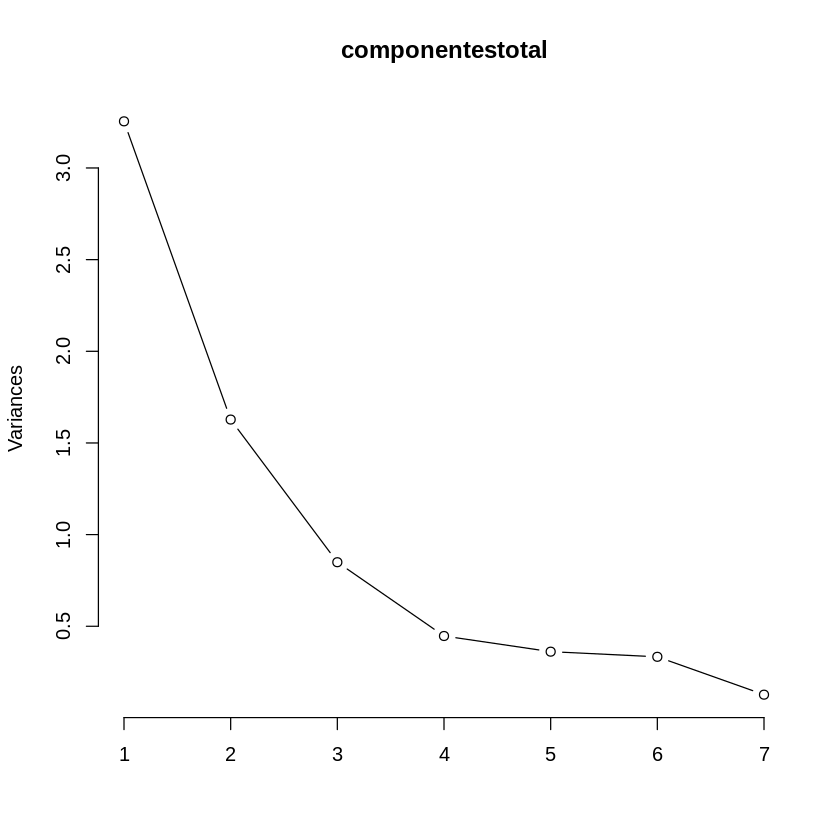

In [11]:
plot(componentestotal, type="l")

Por tratarse de un método no supervisado no existe un criterio establecido para definir cuántos componentes principales usar como reducción de las variables originales. Las opciones son:

    Elegido por dominio (a priori): El problema de negocio da pistas sobre cuántos componentes se requiere o es viable trabajar.
    Uso de eigenvalues: usar componentes que expliquen más de una variable, o sea, de autovalor (eigenvalue) superior a 1.
    Determinar un porcentaje de la varianza a alcanzar. La ley de los pocos vitales usa el 80% de proporción acumulada como valor empírico de corte.
    Gráfico de sedimentación: revisar en dónde el gráfico de sedimentación genera un "codo" o cambio de pendiente.

El criterio B implicaría el uso de 2 componentes; el criterio C manejaría 3. El gráfico de sedimentación ubica el valor aproximadamente entre 2 o 3 componentes. En este caso vamos a utilizar 2 componentes principales (69.7% de la variabilidad) pues va a facilitar el análisis.

In [12]:
componentes<-prcomp(carteraz, center=TRUE, scale.=TRUE, rank.=2)
print(componentes)

Standard deviations (1, .., p=7):
[1] 1.8039810 1.2757520 0.9216342 0.6685236 0.6012198 0.5774266 0.3562151

Rotation (n x k) = (7 x 2):
                          PC1        PC2
MESES              -0.3840616 -0.3594673
igualowner         -0.4097986 -0.2576352
yearsadress        -0.2875265 -0.3875201
ventasmesaverage   -0.4475191 -0.1280032
pasivo_sobre_venta -0.1887001  0.6355095
carteraA           -0.4146857  0.3449225
carteraB           -0.4405054  0.3391267


La tabla mostrada presenta los valores estandarizados del vector del componente seleccionado, llamados autovectores. A partir de ellos se calcularía la puntuación factorial para cada IPS.
Evaluation

Para interpretar los autovectores, lo usual es mirar qué variables tienen valores altos en el vector. Esas serán las variables mejor representadas en el mismo. Para ello haremos un gráfico:


Attaching package: ‘ggplot2’


The following objects are masked from ‘package:psych’:

    %+%, alpha


Using medicion as id variables



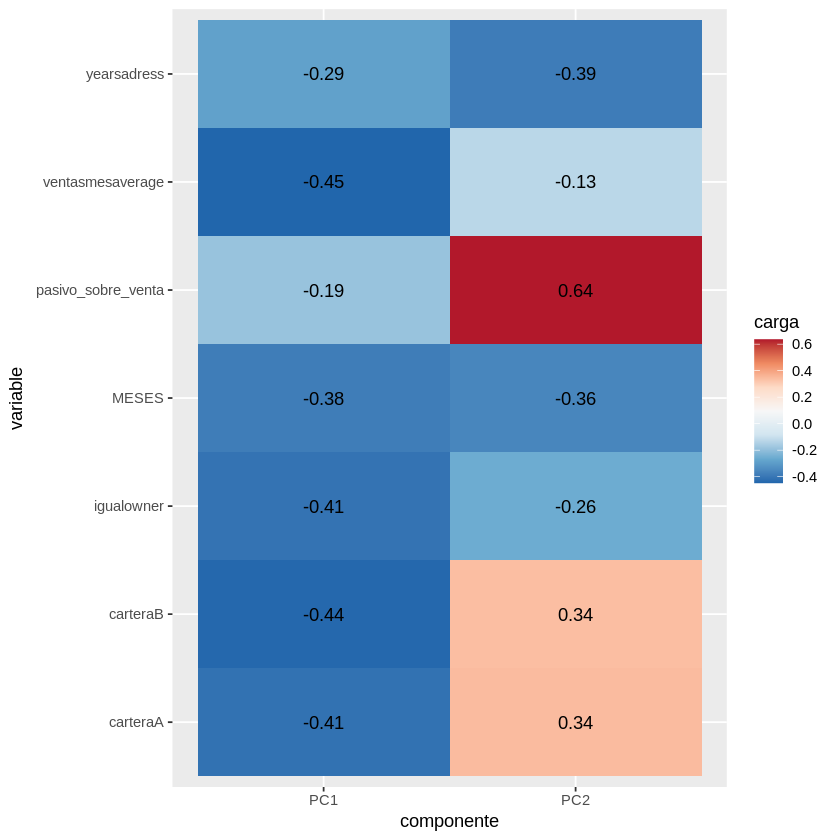

In [13]:
library(reshape2)
library(ggplot2)
cargas<-componentes$rotation
cargasdf<-as.data.frame(cargas)
cargasdf$medicion<-rownames(cargasdf)
cargasheat<-reshape2::melt(cargasdf)
colnames(cargasheat)<-c("variable","componente","carga")
library(ggplot2)
ggplot(cargasheat,aes(x=componente,y=variable,fill=carga, label=sprintf("%0.2f", round(carga, digits=2))))+geom_tile()+scale_fill_distiller(palette="RdBu")+geom_text()

Por ejemplo, aunque el primer componente tiene valores similares en todas las variables, las 4 más altas en valor absoluto (por encima de 0.4) son las carteras A y B, las ventas promedio y el tiempo con el mismo dueño. En el segundo componente la variable que puntúa más alto es el pasivo sobre venta. El componente 2 muestra que a mayores pasivos sobre venta tiende a tener la IPS, menores años en la dirección actual tiende a tener. De nuevo, cuántas variables ayudan a explicar o representar el componente es un asunto de juicio. La regla empírica que utilizo es tantas como la variabilidad representada por el autovalor. En este caso, el primer componente tendría casi 4 y el segundo entre 1 y 2.
Al realizar interpretaciones de dichos autovectores como factores latentes, entramos en el campo del análisis factorial. Por ejemplo, si digo que el primer componente representa la pequeñez e inestabilidad de la empresa, y el segundo su nivel de endeudamiento, estoy asignando interpretaciones como factores latentes a los autovectores que pueden ayudarme posteriormente a interpretar mi modelo. Para este caso, si quiero mejorar la interpretación puedo recurrir a una rotación:

In [14]:
library(psych)
componentes2<-principal(carteraz,nfactors=2,rotate="varimax")
# rotaciones disponibles: "none", "varimax", "quatimax", "promax", "oblimin", "simplimax", and "cluster"
componentes2$communality
componentes2$loadings

MESES         igualowner        yearsadress   ventasmesaverage 
         0.6903328          0.6545482          0.5134528          0.6784262 
pasivo_sobre_venta           carteraA           carteraB 
         0.7731995          0.7532626          0.8186686


Loadings:
                   RC1    RC2   
MESES               0.828       
igualowner          0.783  0.204
yearsadress         0.714       
ventasmesaverage    0.733  0.376
pasivo_sobre_venta -0.239  0.846
carteraA            0.310  0.810
carteraB            0.351  0.834

                 RC1   RC2
SS loadings    2.622 2.260
Proportion Var 0.375 0.323
Cumulative Var 0.375 0.697

In [20]:
# Miremos qué pasa si usamos la rotación quartimax
componentes3<-principal(carteraz,nfactors=2,rotate="quartimax")
# rotaciones disponibles: "none", "varimax", "quartimax", "promax", "oblimin", "simplimax", and "cluster"
componentes3$communality
componentes3$loadings

Loading required namespace: GPArotation



MESES         igualowner        yearsadress   ventasmesaverage 
         0.6903328          0.6545482          0.5134528          0.6784262 
pasivo_sobre_venta           carteraA           carteraB 
         0.7731995          0.7532626          0.8186686


Loadings:
                   RC1    RC2   
MESES               0.830       
igualowner          0.790  0.173
yearsadress         0.711       
ventasmesaverage    0.747  0.346
pasivo_sobre_venta -0.205  0.855
carteraA            0.343  0.797
carteraB            0.385  0.819

                 RC1   RC2
SS loadings    2.685 2.197
Proportion Var 0.384 0.314
Cumulative Var 0.384 0.697

Las comunalidades permiten ver la cantidad o porcentaje de la varianza de cada variable que la solución factorial representa. La variable mejor representada es la cartera B, mientras que la menor representada es la de años en la dirección actual.

Grafiquemos las puntuaciones:

Using medicion as id variables



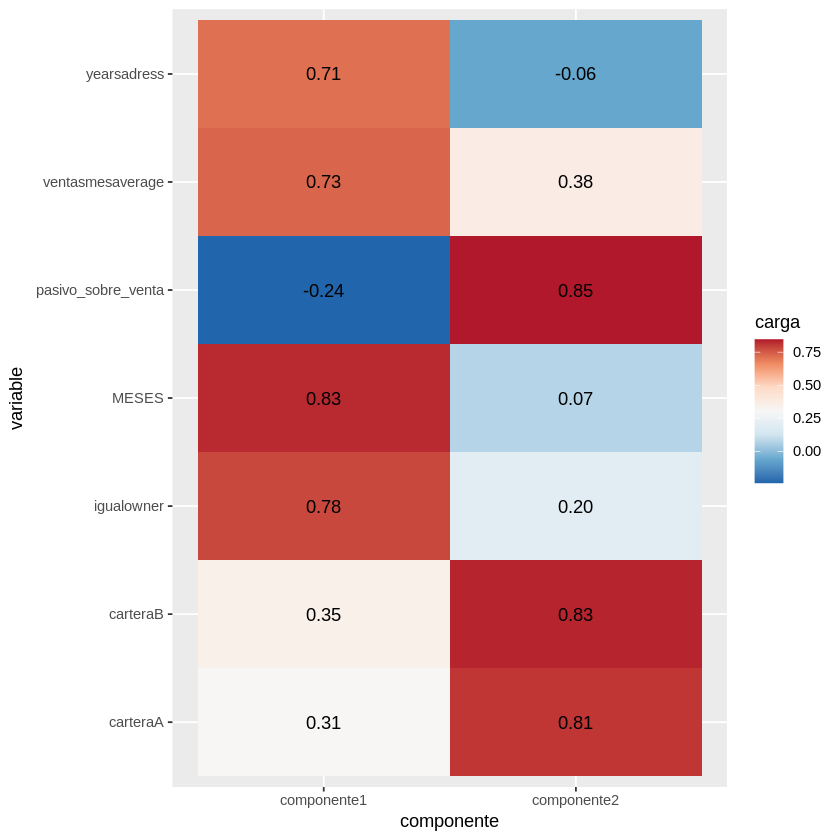

In [16]:
componente1<-componentes2$loadings[,1]
componente2<-componentes2$loadings[,2]

cargasdfr<-as.data.frame(cbind(componente1,componente2))
cargasdfr$medicion<-rownames(cargasdfr)
cargasheatr<-reshape2::melt(cargasdfr)
colnames(cargasheatr)<-c("variable","componente","carga")
ggplot(cargasheatr,aes(x=componente,y=variable,fill=carga, label=sprintf("%0.2f", round(carga, digits=2))))+geom_tile()+scale_fill_distiller(palette="RdBu")+geom_text()

Si bien la solución factorial no cambia pues la interpretación varía un poco. Ahora es más claro que el componente 1 representa una antigüedad con algo de tamaño (meses de cliente, años en la dirección actual y con el mismo dueño) mientras que el componente 2 representa la deuda.

Una vez tenemos la interpretación, y si nos satisface la reducción obtenida, podemos guardar las puntuaciones factoriales en la base de datos:

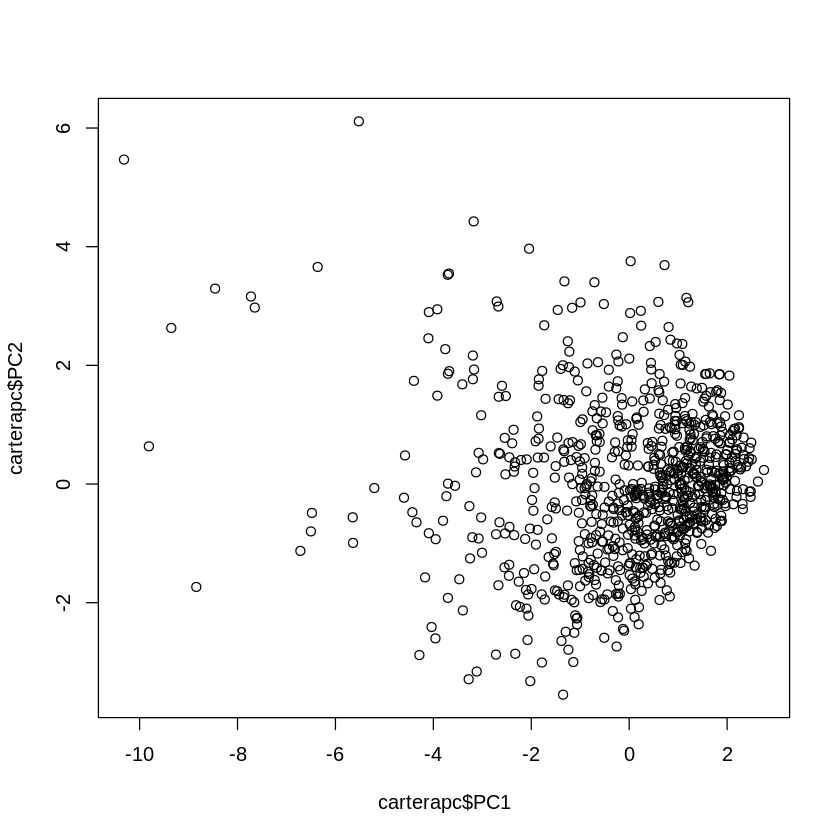

In [17]:
#guardo las puntuaciones factoriales- ojo son las de la primera solución
pc<-componentes$x
#uno las dos columnas a la base inicial
carterapc<-cbind(cartera,pc)
carterapc$retrasos<-as.factor(carterapc$retrasos)
#dos gráficos
plot(carterapc$PC1,carterapc$PC2)

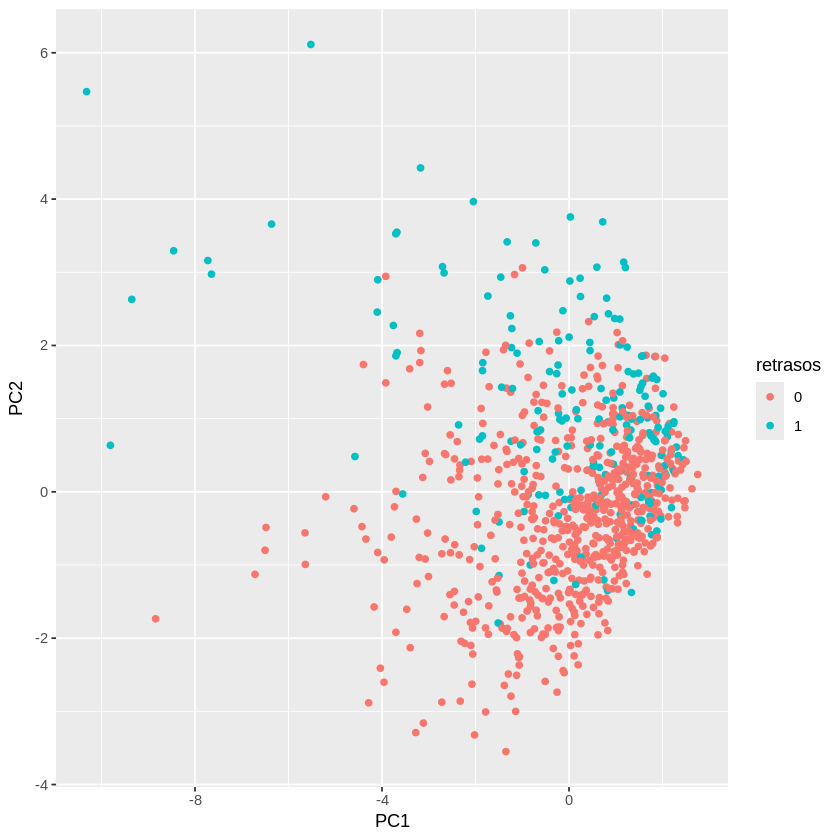

In [18]:
ggplot(carterapc,aes(x=PC1,y=PC2,color=retrasos))+geom_point()

Obsérvese que guardamos la solución no rotada para la interpretación. Cuando el componente 1 (pequeñez) es bajo, el componente 2 (deuda) separa los retrasos. La interpretación es que en las empresas grandes, el tamaño de la deuda permitirá prever si habrá o no retrasos. La división es menos clara cuando el tamaño de la empresa es pequeño.

Hagámoslo con la solución rotada:

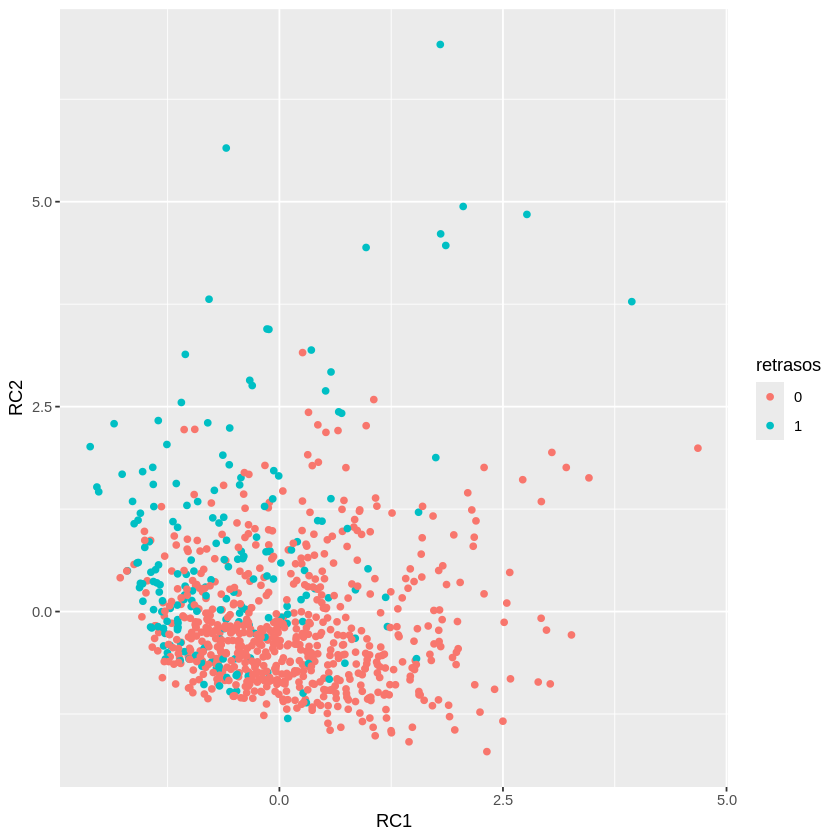

In [19]:
#guardo las puntuaciones factoriales
pca<-componentes2$scores
#uno las dos columnas a la base inicial
carterapca<-cbind(cartera,pca)
carterapca$retrasos<-as.factor(carterapca$retrasos)

ggplot(carterapca,aes(x=RC1,y=RC2,color=retrasos))+geom_point()

Como análisis, Cuando el componente de antiguedad-tamaño es alto, la deuda me permite predecir si habrá o no retrasos.